In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from os import path
from wordcloud import WordCloud
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer, HashingVectorizer
from sklearn.decomposition import TruncatedSVD
# import xgboost as xgb

In [2]:
import os

In [3]:
os.chdir("C:/Users/Shardul Janaskar/Downloads")

In [4]:
df = pd.read_csv("quora_duplicate_questions.tsv", delimiter = '\t', encoding = 'utf-8')

In [5]:
df1 = df.copy()

In [6]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [7]:
df.shape

(404290, 6)

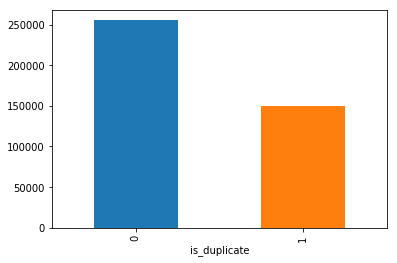

In [8]:
qid = df.groupby("is_duplicate")["id"].count().plot.bar()

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
id              404290 non-null int64
qid1            404290 non-null int64
qid2            404290 non-null int64
question1       404289 non-null object
question2       404288 non-null object
is_duplicate    404290 non-null int64
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


In [10]:
df['len_1'] = df.question1.apply(lambda x : len(str(x)))
df['len_2'] = df.question2.apply(lambda x : len(str(x)))
df['diff_len'] = abs(df.len_1 - df.len_2)
df['len_char_1'] = df.question1.apply(lambda x : len(''.join(set(str(x).replace(' ','')))))
df['len_char_2'] = df.question2.apply(lambda x : len(''.join(set(str(x).replace(' ','')))))
df['len_word_1'] = df.question1.apply(lambda x : len(str(x).split()))
df['len_word_2'] = df.question2.apply(lambda x : len(str(x).split()))

In [11]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate,len_1,len_2,diff_len,len_char_1,len_char_2,len_word_1,len_word_2
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,66,57,9,20,20,14,12
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,51,88,37,21,29,8,13
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,73,59,14,25,24,14,10
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,50,65,15,19,26,11,9
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,76,39,37,25,18,13,7


In [13]:
df = df.fillna('')

nan_rows = df[df.isnull().any(1)]
print (nan_rows)

Empty DataFrame
Columns: [id, qid1, qid2, question1, question2, is_duplicate, len_1, len_2, diff_len, len_char_1, len_char_2, len_word_1, len_word_2]
Index: []


In [16]:
def normalized_word_Total(row):
    w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
    return (len(w1) + len(w2))

df['word_Total'] = df.apply(normalized_word_Total, axis=1)

In [27]:
def normalized_word_share(row):
    w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" "))) 
    return len(w1 & w2)/(len(w1) + len(w2))
df['word_share'] = df.apply(normalized_word_share, axis=1)

In [28]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate,len_1,len_2,diff_len,len_char_1,len_char_2,len_word_1,len_word_2,word_Total,word_share
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,66,57,9,20,20,14,12,23,0.434783
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,51,88,37,21,29,8,13,20,0.200000
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,73,59,14,25,24,14,10,24,0.166667
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,50,65,15,19,26,11,9,19,0.000000
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,76,39,37,25,18,13,7,20,0.100000


C:\Users\Shardul Janaskar\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
C:\Users\Shardul Janaskar\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\Users\Shardul Janaskar\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


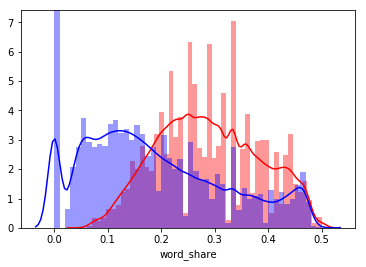

In [30]:
import seaborn as sns
sns.distplot(df[df["is_duplicate"] == 1]["word_share"][0:], label = "1", color = 'red')
sns.distplot(df[df["is_duplicate"] == 0]["word_share"][0:], label = "0", color = 'blue')

In [31]:
df.to_pickle('quora_preprocess.pkl')